In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PREPARE THE LIBRARY

In [2]:
from google.colab import files
import pandas as pd
import json
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding,Bidirectional, LSTM, LayerNormalization, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

PREPARE DATASET

In [3]:
df = pd.read_csv('/content/drive/MyDrive/CAPSTONE/improve_model/data_train.csv')
df

,tag,patterns
0,salam,Hai
1,salam,Hay
2,salam,Apakah ada orang di sana?
3,salam,Hai yang di sana
4,salam,Halo
...,...,...
574,about_mentalillness,bisakah kau jelaskan kepada saya apa itu menta...
575,about_mentalillness,jelaskan apa itu mental illnes
576,about_mentalillness,jelaskan apa itu penyakit mental
577,about_mentalillness,definisikan pengertian penyakit mental?


In [4]:
with open('/content/drive/MyDrive/CAPSTONE/improve_model/respon.json', 'r') as f:
    respon = json.load(f)

In [5]:
data_respon = []
for example in respon:
  temp_tag = example['tag']
  temp_respon = []
  for respons in example['responses']:
    temp_respon.append(respons)
  temp=[temp_tag,temp_respon]
  data_respon.append(temp)
data_respon


[['salam',
  ['Halo yang disana.Katakan padaku bagaimana perasaanmu hari ini?',
   'Hai, yang di sana.Apa yang membawamu ke sini hari ini?',
   'Hai, yang di sana.Bagaimana perasaan Anda hari ini?',
   'Senang bertemu denganmu.Bagaimana perasaan Anda saat ini?',
   'Halo yang disana.Senang melihat Anda kembali.Apa yang terjadi di dunia Anda saat ini?']],
 ['sedih',
  ['Saya turut berduka mendengarnya.Aku di sini Untukmu.Membicarakannya mungkin membantu.Jadi, beri tahu saya mengapa menurut Anda Anda merasa seperti ini?',
   'Aku di sini Untukmu.Bisakah Anda memberi tahu saya mengapa Anda merasa seperti ini?',
   'Menurut Anda mengapa Anda merasa seperti ini?',
   'Sudah berapa lama Anda merasa seperti ini?']],
 ['senang',
  ['Senang mendengar.Saya senang Anda merasa seperti ini.',
   'Oh begitu. Itu hebat.',
   'Apakah sesuatu terjadi yang membuat Anda merasa seperti ini?']],
 ['takut',
  ['Wajar untuk merasakan hal ini.Aku di sini Untukmu.',
   'Semuanya akan baik -baik saja.Perasaan i

In [6]:
data_respon = pd.DataFrame(data_respon,columns=['tag','responses'])
data = data_respon[data_respon['tag']=='sedih']
data_respon
# print(data['responses'].values[0][0])

,tag,responses
0,salam,[Halo yang disana.Katakan padaku bagaimana per...
1,sedih,[Saya turut berduka mendengarnya.Aku di sini U...
2,senang,[Senang mendengar.Saya senang Anda merasa sepe...
3,takut,[Wajar untuk merasakan hal ini.Aku di sini Unt...
4,bunuh diri,[Saya sangat menyesal mendengarnya tetapi Anda...
5,Selesai,[Saya mendengar Anda dan mencatat semuanya.Sam...
6,about_mentalhealth,[Kesehatan mental adalah keadaan kesejahteraan...
7,about_depression,[Depresi merupakan gangguan kesehatan mental y...
8,about_mentalillness,[Penyakit mental adalah kondisi kesehatan yang...


In [7]:
df['Jumlah_Kata'] = df['patterns'].apply(lambda x: len(x.split()))
df = df[df['Jumlah_Kata'] <= 100]
df = df.drop(columns=['Jumlah_Kata'])


In [8]:
jmlh_kelas = len(df['tag'].unique())
jmlh_kelas

9

In [9]:
df['tag'].value_counts()

sedih                  110
senang                 107
takut                  105
bunuh diri             103
Selesai                 13
salam                   12
about_depression        10
about_mentalhealth       9
about_mentalillness      8
Name: tag, dtype: int64

In [10]:
lbl_enc = LabelEncoder()
label = lbl_enc.fit_transform(df['tag'])
label

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
       7, 7, 7, 7, 7, 8, 8, 8, 8, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

In [41]:
tokenizer = Tokenizer(lower = True,num_words=1000,oov_token= "<OOV>")
tokenizer.fit_on_texts(df['patterns'])
total_words = len(tokenizer.word_index)+1
sequences = tokenizer.texts_to_sequences(df['patterns'])
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, label, test_size=0.1, random_state=42,stratify=label)
max_sequence_length

115

MODEL TRAINING

In [44]:
class Mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    val_acc = logs["val_accuracy"]
    train_acc = logs["accuracy"]
    if val_acc > 0.70 and train_acc > 0.85:
      self.model.stop_training = True

callbacks = Mycallback()
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(jmlh_kelas, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train,y_train,epochs=50,validation_data=(X_val,y_val),callbacks=[callbacks])

Epoch 1/50
14/14 [==============================] - 60s 750ms/step - loss: 1.9537 - accuracy: 0.2354 - val_loss: 1.7681 - val_accuracy: 0.2083
Epoch 2/50
14/14 [==============================] - 13s 889ms/step - loss: 1.7070 - accuracy: 0.3124 - val_loss: 1.6480 - val_accuracy: 0.3125
Epoch 3/50
14/14 [==============================] - 12s 892ms/step - loss: 1.5235 - accuracy: 0.3636 - val_loss: 1.4902 - val_accuracy: 0.3750
Epoch 4/50
14/14 [==============================] - 10s 665ms/step - loss: 1.3197 - accuracy: 0.3916 - val_loss: 1.2225 - val_accuracy: 0.4167
Epoch 5/50
14/14 [==============================] - 13s 918ms/step - loss: 1.1091 - accuracy: 0.4732 - val_loss: 1.0605 - val_accuracy: 0.4792
Epoch 6/50
14/14 [==============================] - 11s 805ms/step - loss: 1.0036 - accuracy: 0.5152 - val_loss: 1.0993 - val_accuracy: 0.4583
Epoch 7/50
14/14 [==============================] - 10s 683ms/step - loss: 0.9795 - accuracy: 0.5688 - val_loss: 1.0250 - val_accuracy: 0.5417

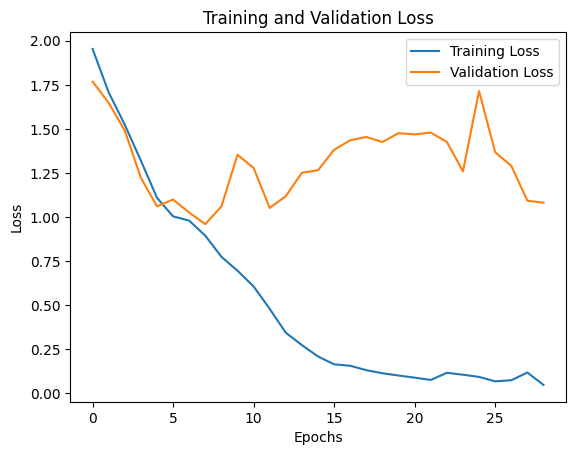

In [45]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


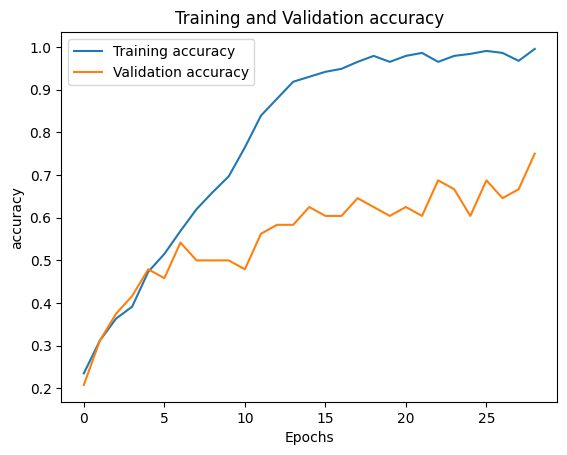

In [46]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Function To Generate answer


In [54]:
def generate_answer(model, tokenizer, max_sequence_length, input_text):
    input_sequence = tokenizer.texts_to_sequences([input_text])
    padded_sequence = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')
    predicted_probabilities = model.predict(padded_sequence)
    predicted_index = np.argmax(predicted_probabilities)
    predicted_tag = lbl_enc.inverse_transform([predicted_index])[0]
    print(predicted_tag)
    respons = data_respon[data_respon['tag']==predicted_tag]['responses'].values[0][0]
    return respons

# Contoh penggunaan fungsi generate_answer
input_text = "hari ini saya mendapat nilai buruk"
predicted_answer = generate_answer(model, tokenizer, max_sequence_length, input_text)
print("Predicted Answer:", predicted_answer)

1/1 [==============================] - 0s 93ms/step
sedih
Predicted Answer: Saya turut berduka mendengarnya.Aku di sini Untukmu.Membicarakannya mungkin membantu.Jadi, beri tahu saya mengapa menurut Anda Anda merasa seperti ini?


Save Model

In [ ]:
!pip install tensorflowjs

In [48]:
model.save("my_model.h5")
!tensorflowjs_converter --input_format keras my_model.h5 path/to/tfjs/model

# Create a ZIP file containing the TensorFlow.js model files
!zip -r tfjs_model.zip path/to/tfjs/model

# Download the ZIP file
files.download('tfjs_model.zip')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  `tf.saved_model.SaveOptions` object that specifies SavedModel


2023-12-08 10:38:11.546916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 10:38:11.547009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 10:38:11.559290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 10:38:13.224373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
updating: path/to/tfjs/model/ (stored 0%)
updating: path/to/tfjs/model/model.json (deflated 80%)
updating: path/to/tfjs/model/group1-shard1of1.bin (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
model.save('model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
files.download('tokenizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
with open('lbl_enc.pkl', 'wb') as file:
    pickle.dump(lbl_enc, file)
files.download('lbl_enc.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>